In [ ]:
# install tensorflow
import tensorflow as tf

# demonstrating transfer learning without data augmentation

if we imagine a CNN as: 

input $→$ body (CNN) $→$ head (RNN)

where the "head" is what outputs the final prediction of regression or classification

transfer learning: when we replace the "body" with a model that's been trained on a huge dataset like ImageNet. models of this type are: 
*   VGG
*   ResNet
*   Inception
*   MobileNet

this notebook will demonstrate how to use transfer learning without data augmentation, instead we will precompute features

In [ ]:
# other imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sys, os

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel
from tensorflow.keras.applications.vgg16 import preprocess_input

from glob import glob

data used for this file is the same as in the transfer learning with augmentation notebook, so look there for more details

In [ ]:
# get data (from: https://mmspg.epfl.ch/downloads/food-image-datasets/)
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2023-05-19 21:41:07--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  21.2MB/s    in 24s     

2023-05-19 21:41:32 (17.9 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [ ]:
# unzip the file (supressing output with -qq option)
!unzip -qq -o Food-5K.zip

In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test
!mkdir data/test/nonfood
!mkdir data/test/food 

In [ ]:
# now move files into appropriate folders
!mv Food-5K/training/0*.jpg data/train/nonfood/
!mv Food-5K/training/1*.jpg data/train/food/
!mv Food-5K/validation/0*.jpg data/test/nonfood/
!mv Food-5K/validation/1*.jpg data/test/food/

# ignore the 3rd directory "evaluation"

In [ ]:
train_path = 'data/train'
test_path = 'data/test'

In [ ]:
imagesize = [200,200]

# easy path to files
image_files = glob(train_path + '/*/*.jpg')
test_image_files = glob(test_path + '/*/*.jpg')

# classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

now onto the model

In [ ]:
ptm = PretrainedModel(input_shape=imagesize+[3], # dimension of images + 3 (color channgels)
                      weights='imagenet',        # want weights from ImageNet
                      include_top=False)         # get layers up to final convolution (i.e. only body)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# map the data into feature vectors 
x = Flatten()(ptm.output)

In [ ]:
# model object
model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# now onto the ImageDataGenerator
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# create generators
batchsize = 128
train_generator = gen.flow_from_directory(train_path,               
                                          target_size=imagesize,    
                                          batch_size=batchsize,
                                          class_mode='binary')     
test_generator = gen.flow_from_directory(test_path,
                                         target_size=imagesize,
                                         batch_size=batchsize,
                                         class_mode='binary')

# class mode set to binary bc we already know targets are, you can also 
# pass in "sparse" 

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# now we'll convert our original data into tabular data
Ntrain = len(image_files)
Ntest = len(test_image_files)

# figure out output size
feat = model.predict(np.random.random([1] + imagesize + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_test = np.zeros((Ntest, D))
Y_test = np.zeros(Ntest)

1/1 [==============================] - 1s 808ms/step


In [ ]:
# populate the train arrays 
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)

  # size of batch (not always batchsize)
  siz = len(y)

  # assign features to Xtrain and Ytrain
  X_train[i:i+siz] = features
  Y_train[i:i+siz] = y

  # move index
  i += siz 
  print(i)
  if i >= Ntrain:
    print('breaking loop, i >= Ntrain')
    break

print(i)

4/4 [==============================] - 55s 14s/step
128
4/4 [==============================] - 55s 14s/step
256
4/4 [==============================] - 56s 14s/step
384
4/4 [==============================] - 55s 14s/step
512
4/4 [==============================] - 56s 14s/step
640
4/4 [==============================] - 56s 14s/step
768
4/4 [==============================] - 56s 14s/step
896
4/4 [==============================] - 54s 14s/step
1024
4/4 [==============================] - 55s 14s/step
1152
4/4 [==============================] - 55s 14s/step
1280
4/4 [==============================] - 54s 14s/step
1408
4/4 [==============================] - 56s 14s/step
1536
4/4 [==============================] - 57s 14s/step
1664
4/4 [==============================] - 60s 15s/step
1792
4/4 [==============================] - 54s 14s/step
1920
4/4 [==============================] - 57s 14s/step
2048
4/4 [==============================] - 55s 14s/step
2176
4/4 [==============================] -

In [ ]:
# populate the test arrays 
i = 0
for x, y in test_generator:
  # get features
  features = model.predict(x)

  # size of batch (not always batchsize)
  siz = len(y)

  # assign features to Xtest and Ytest
  X_test[i:i+siz] = features
  Y_test[i:i+siz] = y

  # move index
  i += siz 
  print(i)
  if i >= Ntest:
    print('breaking loop, i >= Ntrain')
    break

print(i)

4/4 [==============================] - 58s 14s/step
128
4/4 [==============================] - 55s 14s/step
256
4/4 [==============================] - 57s 14s/step
384
4/4 [==============================] - 56s 14s/step
512
4/4 [==============================] - 54s 14s/step
640
4/4 [==============================] - 53s 13s/step
768
4/4 [==============================] - 53s 13s/step
896
4/4 [==============================] - 44s 10s/step
1000
breaking loop, i >= Ntrain
1000


In [19]:
# check range of values for the features (min should be 0 as were using relu)
X_train.max(), X_train.min()

(650.8262939453125, 0.0)

In [21]:
# range is large, so scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

In [22]:
# for logistic regression, instead of building from scratch we'll use sklearn
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print('train accuracy:', logr.score(X_train2, Y_train))
print('test accuracy:', logr.score(X_test2, Y_test))

train accuracy: 1.0
test accuracy: 0.979


In [23]:
# double check with logistic regression in TF
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i,x)

In [24]:
# compile and fit (not using scaled data)
linearmodel.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

r = linearmodel.fit(X_train, Y_train, 
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_test, Y_test))

Epoch 1/10
24/24 [==============================] - 2s 38ms/step - loss: 0.6776 - accuracy: 0.9457 - val_loss: 0.3352 - val_accuracy: 0.9770
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0906 - accuracy: 0.9900 - val_loss: 0.3100 - val_accuracy: 0.9790
Epoch 3/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0108 - accuracy: 0.9983 - val_loss: 0.3480 - val_accuracy: 0.9790
Epoch 4/10
24/24 [==============================] - 0s 10ms/step - loss: 8.2973e-04 - accuracy: 0.9997 - val_loss: 0.3211 - val_accuracy: 0.9750
Epoch 5/10
24/24 [==============================] - 0s 11ms/step - loss: 4.6651e-04 - accuracy: 0.9997 - val_loss: 0.3226 - val_accuracy: 0.9760
Epoch 6/10
24/24 [==============================] - 0s 11ms/step - loss: 5.7902e-06 - accuracy: 1.0000 - val_loss: 0.3180 - val_accuracy: 0.9760
Epoch 7/10
24/24 [==============================] - 0s 18ms/step - loss: 2.0064e-06 - accuracy: 1.0000 - val_loss: 0.3181 - val_accuracy: 0.97

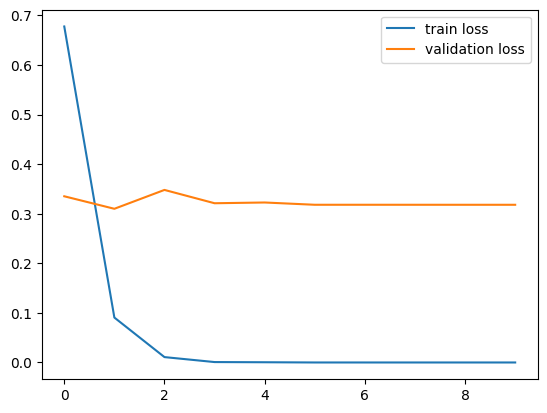

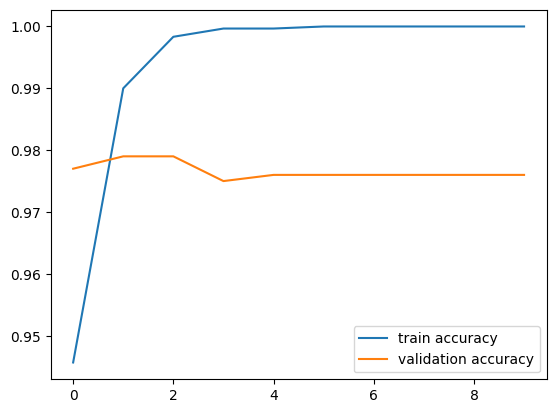

In [25]:
# loss and accuracy 
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

results are pretty good! and way faster than data augmentation